# Analysis of variance (ANOVA)

## Definitions

## Formulas

## Example

## Explanations

## Discussion

### Equivalence between ANOVA and OLS

via https://stats.stackexchange.com/questions/175246/why-is-anova-equivalent-to-linear-regression

In [1]:
import numpy as np
from scipy.stats import randint, norm
np.random.seed(124)  # Fix the seed

x = randint(1,6).rvs(100) # Generate 100 random integer U[1,5]
y = x + norm().rvs(100)   # Generate my response sample

x
1    1.114427
2    1.958159
3    2.844082
4    4.198083
5    5.410594
Name: y, dtype: float64

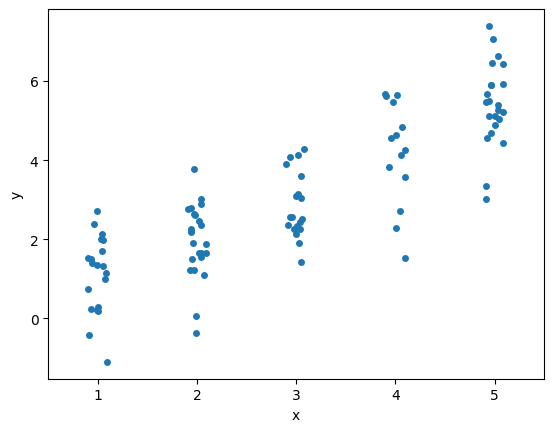

In [2]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({"x":x, "y":y})
sns.stripplot(data=df, x="x", y="y")
df.groupby("x")["y"].mean()

In [3]:
# One-way ANOVA
from scipy.stats import f_oneway

x1 = df[x==1]["y"]
x2 = df[x==2]["y"]
x3 = df[x==3]["y"]
x4 = df[x==4]["y"]
x5 = df[x==5]["y"]
res = f_oneway(x1, x2, x3, x4, x5)
res

F_onewayResult(statistic=62.07182379512491, pvalue=1.113218183344844e-25)

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# get ANOVA table as R like output
model = ols('y ~ C(x)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(x),250.940237,4.0,62.071824,1.113218e-25
Residual,96.015072,95.0,NaN,NaN


In [5]:
# MEANS
# 1    1.114427
# 2    1.958159
# 3    2.844082
# 4    4.198083
# 5    5.410594

# Ordinary Least Squares (OLS) model
model = ols('y ~ C(x)', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     62.07
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           1.11e-25
Time:                        14:57:13   Log-Likelihood:                -139.86
No. Observations:                 100   AIC:                             289.7
Df Residuals:                      95   BIC:                             302.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1144      0.225      4.957      0.000       0.668       1.561
C(x)[T.2]      0.8437      0.304      2.772      0.007       0.239       1.448
C(x)[T.3]      1.7297      0.322      5.370      0.000       1.090       2.369
C(x)[T.4]      3.0837      0.350      8.802      0.000       2.388       3.779
C(x)[T.5]      4.2962      0.307     13.977      0.000       3.686       4.906
==============================================================================
Omnibus:                        3.712   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                3.318
Skew:                          -0.444   Prob(JB):                        0.190
Kurtosis:                       3.084   Cond. No.                         5.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
betas = model.params.values
betas

array([1.11442735, 0.84373124, 1.72965468, 3.0836561 , 4.29616654])

In [7]:
scaled_batas = np.concatenate([[betas[0]], betas[0]+betas[1:]])
scaled_batas

array([1.11442735, 1.95815859, 2.84408203, 4.19808345, 5.41059388])

In [8]:
# Check if the two results are numerically equivalent
np.isclose(scaled_batas, df.groupby("x")["y"].mean().values)

array([ True,  True,  True,  True,  True])

In [9]:
# # Ordinary Least Squares (OLS) model (no intercept)
# model = ols('y ~ C(x) -1', data=df).fit()
# model.summary()

In [70]:
from scipy.stats.mstats import argstoarray
data = argstoarray(x1.values, x2.values, x3.values, x4.values, x5.values)

In [48]:
data.count(axis=1)
np.sum( data.count(axis=1) * ( data.mean(axis=1) - data.mean() )**2 )

250.9402371658938

In [65]:
# sswg manual compute
gmeans = data.mean(axis=1)
data_minus_gmeans = np.subtract(data.T, gmeans).T
(data_minus_gmeans**2).sum()

96.01507202947789

In [69]:
# sswg via parallel axis thm
gmeans = data.mean(axis=1)
np.sum( (data**2).sum(axis=1) - data.count(axis=1) * gmeans**2 )

96.01507202947788

In [45]:
from scipy.stats import f as fdist

def f_oneway(*args):
    """
    Performs a 1-way ANOVA, returning an F-value and probability given
    any number of groups.  From Heiman, pp.394-7.
    """
    # Construct a single array of arguments: each row is a group
    data = argstoarray(*args)
    ngroups = len(data)
    ntot = data.count()
    sstot = (data**2).sum() - (data.sum())**2/float(ntot)
    ssbg = (data.count(-1) * (data.mean(-1)-data.mean())**2).sum()
    sswg = sstot-ssbg
    print(ssbg, sswg, sstot)
    dfbg = ngroups-1
    dfwg = ntot - ngroups
    msb = ssbg/float(dfbg)
    msw = sswg/float(dfwg)
    f = msb/msw
    prob = fdist.sf(dfbg, dfwg, f)
    return f, prob


In [46]:
f_oneway(x1.values, x2.values, x3.values, x4.values, x5.values)

250.9402371658938 96.01507202947755 346.95530919537134


(62.07182379512513, 1.697371507321727e-08)